<div style="display: flex; align-items: center; justify-content: space-between;">
  <div style="flex: 1;">
    <h1>InSAR4SM: Interferometric Synthetic Aperture Radar for Soil Moisture Estimation</h1>
  </div>
  <div style="flex: 0 0 auto; margin-left: 20px;">
    <img src="./figures/insar4sm_logo.png" width="150"/>
  </div>
</div>

Import libraries

In [1]:
import os
from joblib import Parallel, delayed
import pandas as pd
import geopandas as gpd
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
from insar4sm.ERA5.ERA5_class import ERA5
from insar4sm.classes import INSAR4SM_stack
from tqdm import tqdm
from insar4sm.joblib_progress_bar import tqdm_joblib
from insar4sm.sm_estimation_funcs import sm_estimation


### Please download the demo data folder from [here](https://drive.google.com/drive/folders/1F9daxdqJeUt52W0ucj8wDwS65sRC0aMo?usp=sharing)
Demo data folder will be downloaded in several Zip files. Please unzip them an create a single folder with all the contents (as appears in GDrive)

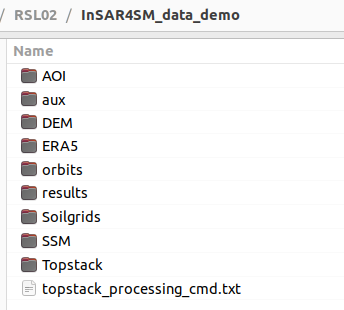

Please provide the directory with the demo data folder

In [2]:
demo_dir = '/RSL02/InSAR4SM_data_demo/'

Setting directories, paths

In [3]:
projectname = 'My_InSAR4SM_App'
AOI_File = os.path.join(demo_dir,'AOI/aoi.geojson')

Please provide the start and end date of your time of interest

In [4]:
# The start and end datetimes for the time span (Format is YYYYMMDDTHHMMSS in UTC)
# Make sure that the time_start is at least one day before the earliest SLC date
time_start = '20180401T000000'
# Make sure that the time_end is at least one day after the latest SLC date
time_end = '20181128T000000'

Please download ERA5-Land meteorological data.  
You should create a .cdsapirc in your HOME directory with your credentials. More info [here](https://cds.climate.copernicus.eu/how-to-api)


In [ ]:
Era5_params_dict = {
    'projectfolder': demo_dir,
    'time_start': time_start,
    'time_end': time_end,
    'AOI_File': AOI_File,
    'ERA5_variables': [
        'volumetric_soil_water_layer_1',
        'total_precipitation',
        'skin_temperature',
    ],
}

In [6]:
# if you change AOI, this takes some time cause it downloads hourly data from ERA5-Land

ERA5_app = ERA5(Era5_params_dict)
ERA5_app.get_download_dates()
ERA5_app.download_ERA5_data()
ERA5_app.create_ERA5_polygons()

#### Please download soil texture data from https://soilgrids.org/. Make sure that your AOI is covered.


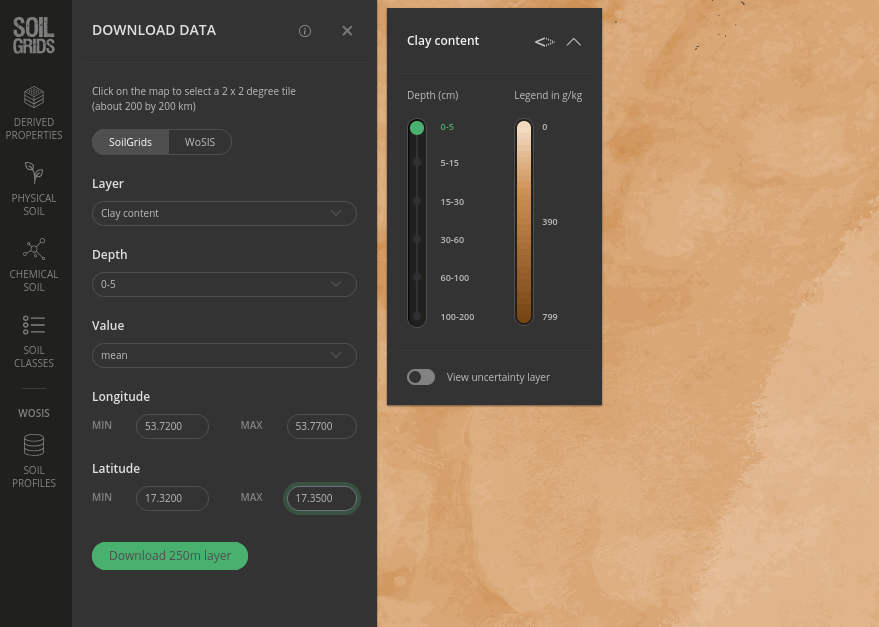

In [ ]:
# soil information datasets (https://soilgrids.org/)
sand_soilgrids = os.path.join(demo_dir,'Soilgrids/sand.tif')
clay_soilgrids = os.path.join(demo_dir,'Soilgrids/clay.tif')

#### Please provide the Topstack Sentinel-1 stack by using ISCE2 Topstack funcionalities.
- Please make sure that your Sentinel-1 acquisitions are between the time_start and time_end you provided.
- Please make sure that your Topstack is covering your provided AOI.

In [8]:
# number of CPUs to be used
n_CPUs = 7

# the directory of the topstack processing stack
topstackDir = os.path.join(demo_dir,'Topstack')

# the output directory 
export_dir = os.path.join(demo_dir,'SSM')

# Closest hour of Sentinel-1 pass (e.g. 12:00:00, 13:00:00, 14:00:00, etc)
orbit_time = '15:00:00'

# half spatial resolution of soil moisture grid in meters
grid_size = 125

# days before each SLC data that cumulative precipitation will be calculated.
days_back = 24

# You can set manually a dry date e.g. one of your SAR acquisition dates (format: YYYYMMDD) or set to None
# set dry_date_manual_flag to True in case you provide manually an dry_date
dry_date = None
dry_date_manual_flag = False

Prepares the InSAR stack

In [ ]:
stack = INSAR4SM_stack(topstackDir = topstackDir,
                       projectname = projectname,
                       n_CPUs = n_CPUs,
                       AOI = AOI_File,
                       meteo_file = ERA5_app.era5_merged_filename,
                       sand = sand_soilgrids,
                       clay = clay_soilgrids,
                       orbit_time = orbit_time,
                       days_back = days_back,
                       export_dir = export_dir)

stack.prepare_datasets()
stack.plot()
# In case of AssertionError, please modify the tp_quantile to select enough SAR acquisitons as 'dry dates'
# tp_quantile = 0.2 means that the 20% of the SAR acquisitions with the lowest accumulated precipitation over the last [days_back] days 
# are representing dry soil moisture conditions
stack.get_dry_SARs(lowest_temp_K = 273.15, tp_quantile = 0.2)
stack.calc_insar_stack()
stack.calc_grid(grid_size = grid_size)

Estimates SSM from InSAR stack utilizing soil and meteo information

In [ ]:
with tqdm_joblib(tqdm(desc="SM Invertions", total=stack.n_sm_points)) as progress_bar:
    sm_estimations_list = Parallel(n_jobs=stack.CPUs)(delayed(sm_estimation)(stack, sm_ind, dry_date_manual_flag, dry_date) for sm_ind in range(stack.n_sm_points))

column_dates = [slc_date.strftime("D%Y%m%d") for slc_date in stack.slc_datetimes]
sm_estimations_df = pd.DataFrame(sm_estimations_list, index = range(stack.n_sm_points), columns = column_dates)

sm_estimations_df['geometry'] = stack.sm_points.values
sm_estimations_gdg = gpd.GeoDataFrame(sm_estimations_df, geometry='geometry')
sm_estimations_gdg.to_file(os.path.join(stack.export_dir,'sm_inversions_{}_{}.shp'.format(projectname,grid_size)))

Comparison of mean INSAR4SM over AOI with ERA5-Land surface soil moisture

In [ ]:
comparison_df = (stack.meteo_sel_df['swvl1']*100).copy().to_frame()

sm_estimations_df.dropna(inplace=True)
if 'geometry' in sm_estimations_df.columns:
    sm_estimations_df.drop(columns='geometry', inplace=True)
comparison_df['sm_inverted'] = sm_estimations_df.mean(axis=0).values
comparison_df.to_csv('{}/comparison_{}.csv'.format(stack.export_dir, grid_size), index=False)

predictions = comparison_df['swvl1'].values
targets = comparison_df['sm_inverted'].values
n = predictions.shape[0]
rmse = np.linalg.norm(predictions - targets) / np.sqrt(n)
r, p_value = pearsonr(predictions, targets)

comparison_df.plot(figsize=(7,4), style='.-')
plt.title('RMSE: {:.2f} m3/m3 \n R: {:.2f}'.format(rmse,r))
plt.savefig('{}/ERA5_comparison_{}.png'.format(stack.export_dir, grid_size), dpi=200)